# Temporal Profiles from Traffic Counters 


This tutorial shows you how to process some measurement data and convert them into profiles for emiproc.

Observed data is usually more accurate than simulated data.
However, you don't have access to observations.

Here we will use traffic data from the city of Zurich to simulate the temporal 
traffic activity with emiproc.

## Download and load the data 

The data is freely available from the city of zurich.

The script will automatically download it, but in case you want to see more, go there:
https://data.stadt-zuerich.ch/dataset/sid_dav_verkehrszaehlung_miv_od2031 

We will use pandas to analyse the data

In [1]:
from pathlib import Path
import urllib.request

year = 2022

local_dir = Path("./traffic_counters")
local_dir.mkdir(exist_ok=True)
local_file = local_dir / "traffic_counters.csv"

download_link = f"https://data.stadt-zuerich.ch/dataset/sid_dav_verkehrszaehlung_miv_od2031/download/sid_dav_verkehrszaehlung_miv_OD2031_{year}.csv"

if not local_file.is_file():
    urllib.request.urlretrieve(download_link, local_file)

    print("Downloaded ", local_file)
else:
    print("File already downloaded ", local_file)

File already downloaded  traffic_counters\traffic_counters.csv


In [2]:
import pandas as pd

df = pd.read_csv(
    local_file,
    # Use only the columns we are interested in
    usecols=[
        "MSID",
        "Kname",
        "EKoord",
        "NKoord",
        "MessungDatZeit",
        "AnzFahrzeuge",
    ],
    # This is the date of measurement column
    parse_dates=["MessungDatZeit"],
)
df.head()

,MSID,EKoord,NKoord,Kname,MessungDatZeit,AnzFahrzeuge
0,Z001M001,2683009.89,1243936.2,Badanstalt Wollishofen,2022-01-01 00:00:00,166.0
1,Z001M001,2683009.89,1243936.2,Badanstalt Wollishofen,2022-01-01 01:00:00,255.0
2,Z001M001,2683009.89,1243936.2,Badanstalt Wollishofen,2022-01-01 02:00:00,168.0
3,Z001M001,2683009.89,1243936.2,Badanstalt Wollishofen,2022-01-01 03:00:00,96.0
4,Z001M001,2683009.89,1243936.2,Badanstalt Wollishofen,2022-01-01 04:00:00,63.0


## Data description

The data measured each hour (column `MessungDatZeit`) how many vehicules (col `AnzFahrzeuge`) 
passed at a specific traffic counter (`MSID`).

Additional data on the traffic counters are also given such as coordinates (`EKoord` and `NKoord`) and names (`ZSName`).

Now we will have a closer look to this data.

First we can extract the station location and see where our counters are located

In [3]:
import numpy as np
import geopandas as gpd

station, indices = np.unique(df["MSID"], return_index=True)


stations = df.iloc[indices]

gdf_stations = gpd.GeoDataFrame(
    {
        col: stations[col]
        for col in [
            "MSID",
            "Kname",
        ]
    },
    geometry=gpd.points_from_xy(stations["EKoord"], stations["NKoord"], crs="LV95"),
)
gdf_stations.explore()

We can have a look to what one of these counters measures.

If we take the first one, we could plot the measurements.

<Axes: title={'center': 'Daily sum'}, xlabel='MessungDatZeit', ylabel='Number of cars/day'>

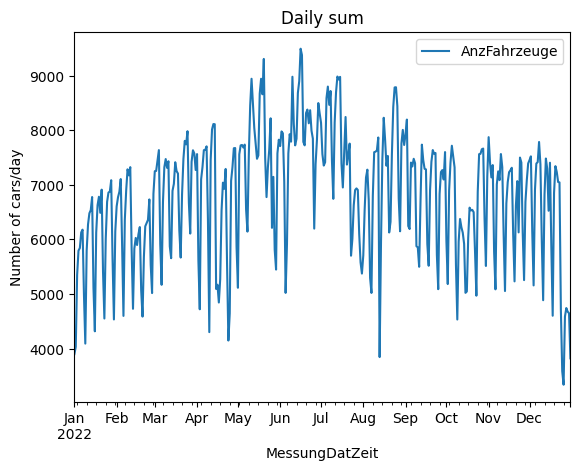

In [4]:
import matplotlib.pyplot as plt

plt.style.use("default")


df_counter1 = df.loc[df["MSID"] == "Z001M001"]

# Resample daily to have less noise
df_counter1.set_index("MessungDatZeit").resample("d").sum().plot(
    y="AnzFahrzeuge", title="Daily sum", ylabel="Number of cars/day"
)

We see here some interesting features.

* Weekly cycle: During the week the traffic is higher than during weekends, which explains the "peaking" behaviour
* During holidays the traffic is much lower (Feburary: 2 weeks holidays, Summer holiday in july, October: 2 weeks holidays and christmas at the end of december )
* Rise of traffic after the COVID pandemic. Switzerland lifted the restrictions on 17th of February. Before and after that day the country was slowly going back to business, which explains the rise in the first mounths of measurements.
* Unexplained peaks. during some period we don't know what happened. Maybe there was an event, a street blocked nearby or any other activity that explain a higher behaviour ?

## Processing for emiproc

If we want to convert this data to emiproc profiles, we need to find the correct data structure.

All profiles are listed in the [API documentation](https://emiproc.readthedocs.io/en/master/api/profiles.html#temporal-profiles). 
Here as we have one value for each hour in the year, it would make sense to use the hour of year profile.

However before we must ensure data consitency.

### Data timezone consistency

When working with time, we usually come across the difference between the local time and the universtal time (UTC).

In our case, from teh data documentation we get that the data is in local time of zurich.
Here we show how to add the time awareness with pandas.

In [5]:
# Extract a serie with the vehicule counts and the time as index
counts = df_counter1.set_index('MessungDatZeit')['AnzFahrzeuge']
counts_local_time = counts.tz_localize("Europe/Zurich", ambiguous=True)
counts_local_time.head()

MessungDatZeit
2022-01-01 00:00:00+01:00    166.0
2022-01-01 01:00:00+01:00    255.0
2022-01-01 02:00:00+01:00    168.0
2022-01-01 03:00:00+01:00     96.0
2022-01-01 04:00:00+01:00     63.0
Name: AnzFahrzeuge, dtype: float64

Now our data is timezone aware. Note the +01:00 at the end of the timestampe, which is the UTC offset.

Based on the use case, we could convert this data to UTC or keep it as it is.
In emiproc we don't have rules, we let the user be responsible.

For this example we will convert the data depending on which profile we want.

### Missing values

Measurement data always has some issues, usually if not to bad we can interpolate the missing values.

It is good to check the data before using any algorithm that replaces missing values, so that 
you know how the replacement impacts your data.

In [6]:
from emiproc.profiles.temporal.constants import N_HOUR_YEAR
# Count the missing values 
print("Got ", len(counts_local_time), "Expected ", N_HOUR_YEAR)

Got  8759 Expected  8760


In [7]:
# Replace the missing values by setting the data on a new axis 
axis = pd.date_range(
    f"{year}-01-01", f"{year+1}-01-01", freq='h', inclusive='left', tz='Europe/Zurich'
)
len(axis)

8760

In [8]:
# Set the data on the new axis and interpolate
# Look at pandas interpolate doc for more information
counts_clean = counts_local_time.reindex(axis).interpolate(method='time')
counts_clean

2022-01-01 00:00:00+01:00    166.0
2022-01-01 01:00:00+01:00    255.0
2022-01-01 02:00:00+01:00    168.0
2022-01-01 03:00:00+01:00     96.0
2022-01-01 04:00:00+01:00     63.0
                             ...  
2022-12-31 19:00:00+01:00    212.0
2022-12-31 20:00:00+01:00    110.0
2022-12-31 21:00:00+01:00    103.0
2022-12-31 22:00:00+01:00    100.0
2022-12-31 23:00:00+01:00    170.0
Freq: h, Name: AnzFahrzeuge, Length: 8760, dtype: float64

### Converting to ratios

Now we need to convert traffic counts to ratio.

Emiproc expects at each time to be given the fraction of total emissions.
So in a profile the sum of the ratios is 1.

[Learn More about Profiles](https://emiproc.readthedocs.io/en/master/profiles.html#emission-profiles)

In [9]:
ratios = counts_clean.values / counts_clean.sum()
ratios

array([6.67222954e-05, 1.02495092e-04, 6.75261785e-05, ...,
       4.13999785e-05, 4.01941538e-05, 6.83300615e-05])

### Creating Hour of Year profiles

Considering that the data is given at every hour, the profile type that matches the best 
is the hour of year profile.

Note that if you are working with a leap your you will have to use the 
HourOfLeapYearProfile instead.

In [10]:
from emiproc.profiles.temporal.profiles import (
    HourOfYearProfile,
    get_leap_year_or_normal,
)
from emiproc.profiles.plot import plot_profile

# Use this function to get leap or normal
profile_type = get_leap_year_or_normal(HourOfYearProfile, year=year)

profile = profile_type(ratios=ratios)
profile

HourOfYearProfile(ratios=array([[6.67222954e-05, 1.02495092e-04, 6.75261785e-05, ...,
        4.13999785e-05, 4.01941538e-05, 6.83300615e-05]]), size=8760)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Hour of year', ylabel='Ratio [-]'>)

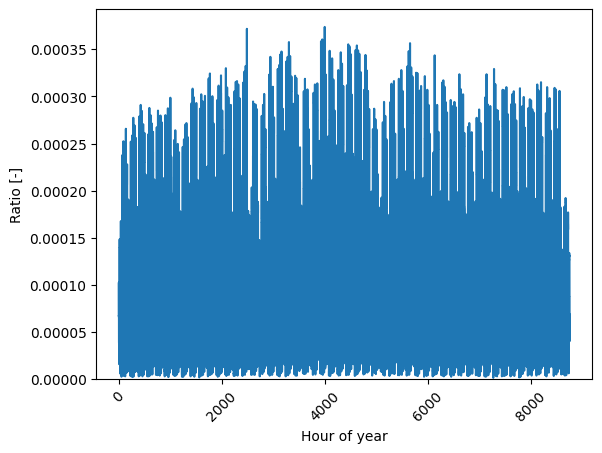

In [11]:
# you can also plot the profiles thanks to emiproc
from emiproc.profiles.plot import plot_profile

plot_profile(profile)

## Converting profiles 

Now that we have an hour of year profile, we could use it in emiproc and assign it to 
an inventory.

However this profile can only be valid for the given year.

If you want to simulate the profile in the future, you can make use of 
`cyclic profiles` which are repeated over time.

For example a mounth of year profile, could then be repeated every year.

Thanks to pandas, it is quite easy to create these profiles, see the following examples.

In [12]:
dt_index: pd.DatetimeIndex = counts_clean.index

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='Ratio [-]'>)

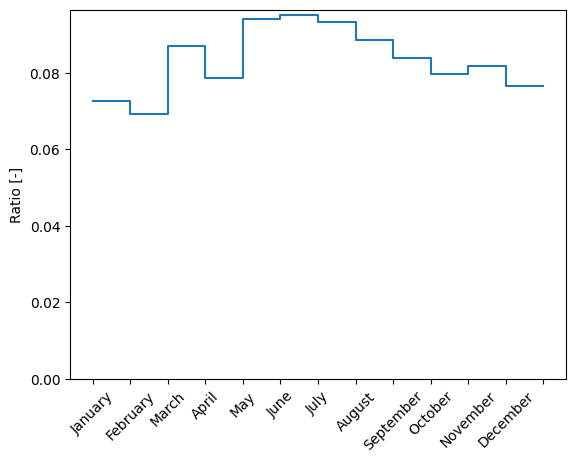

In [13]:
# Create a month of year profile
from emiproc.profiles.temporal.profiles import MounthsProfile

counts_per_mounth = counts_clean.groupby(dt_index.month).sum()

mount_of_year_profile = MounthsProfile(counts_per_mounth.values / counts_per_mounth.sum())
plot_profile(mount_of_year_profile)

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='Ratio [-]'>)

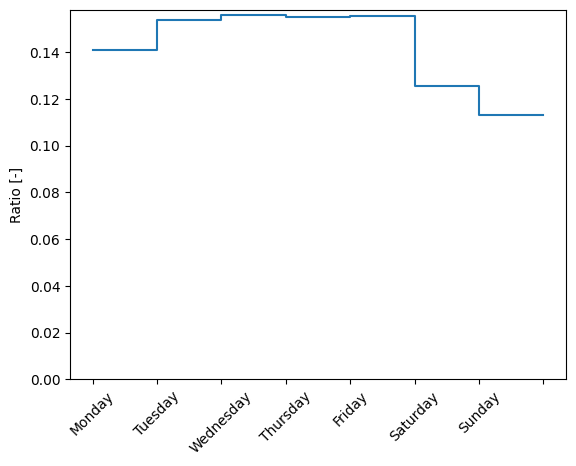

In [14]:
# Create a day of week profile
from emiproc.profiles.temporal.profiles import WeeklyProfile 

# Here I prefer taking the mean instead of sum 
# because depending how the year starts
# some weekday might be more represented if we do the sum
counts_per_weekday = counts_clean.groupby(dt_index.dayofweek).mean()

weekly_profile = WeeklyProfile(counts_per_weekday.values / counts_per_weekday.sum())
plot_profile(weekly_profile)


Notice here that during the weekend, there is a smaller traffic than during the week.
Also monday seems to have less traffic.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Hour of day', ylabel='Ratio [-]'>)

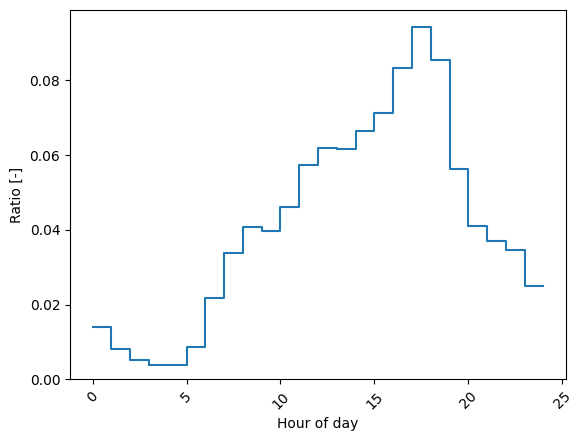

In [15]:
# Create daily profile 
from emiproc.profiles.temporal.profiles import DailyProfile

counts_hour_of_day = counts_clean.groupby(dt_index.hour).sum()

daily_profile = DailyProfile(counts_hour_of_day.values / counts_hour_of_day.sum())
plot_profile(daily_profile)

We have seen that the traffic differs between weekdays and weekends.

We can create HourOfDay profiles for specific days of the week.

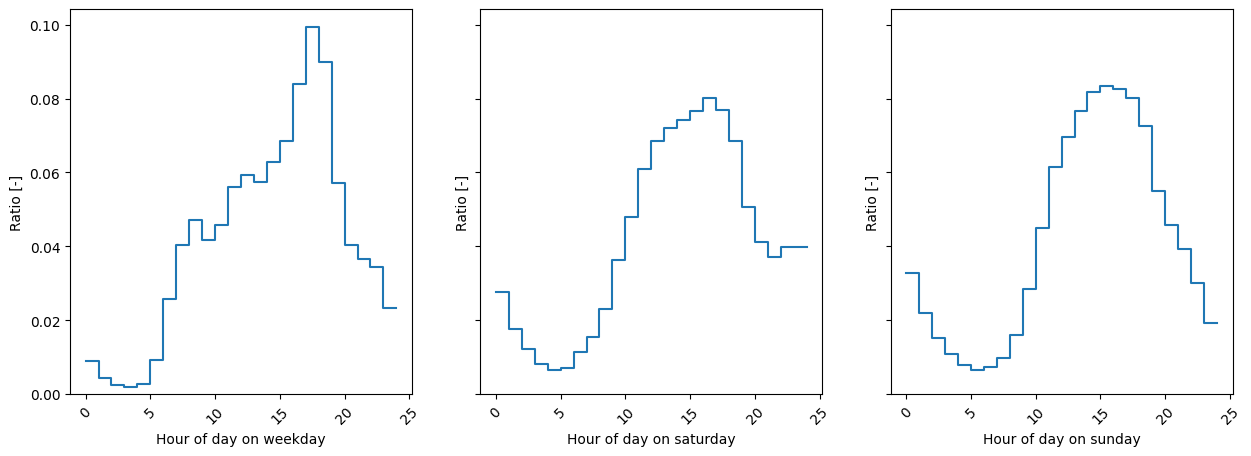

In [16]:
from emiproc.profiles.temporal.profiles import SpecificDayProfile
from emiproc.profiles.temporal.specific_days import SpecificDay, get_days_as_ints


day_types = [SpecificDay.WEEKDAY, SpecificDay.SATURDAY, SpecificDay.SUNDAY]

fig, ax = plt.subplots(ncols=len(day_types), sharey=True, figsize=(15, 5))

specific_day_profiles = []
for col, day in enumerate(day_types):
    mask = dt_index.weekday.isin(get_days_as_ints(day))

    counts_this = counts_clean.loc[mask].groupby(dt_index[mask].hour).sum()
    profile = SpecificDayProfile(counts_this.values / counts_this.sum(), specific_day=day)

    plot_profile(profile, ax=ax[col])

    specific_day_profiles.append(profile)


We see what we expect, the traffic during week has earlier increase in the morning.
Saturday has more traffic in the evening because of the people going out.

## Using the profiles

Now that we have created the profiles, we can use them in emiproc.


### Simulating traffic with emiproc

These profiles can typically be used by an emission model to simulate traffic.
Let's see how we can use them in emiproc.

In [17]:
from emiproc.profiles.temporal.operators import create_scaling_factors_time_serie

# This function simulates the profiles 
ts = create_scaling_factors_time_serie(
    start_time="2022-01-01 00:00:00",
    end_time="2023-01-01 00:00:00",
    # Put the profiles generated above in a list
    profiles=specific_day_profiles + [weekly_profile, mount_of_year_profile],
    # Specify the time zone
    local_tz="Europe/Zurich",
    inclusive="left",
)
ts

2022-01-01 01:00:00+01:00    0.324655
2022-01-01 02:00:00+01:00    0.226490
2022-01-01 03:00:00+01:00    0.150801
2022-01-01 04:00:00+01:00    0.122490
2022-01-01 05:00:00+01:00    0.128903
                               ...   
2022-12-31 20:00:00+01:00    0.798123
2022-12-31 21:00:00+01:00    0.718024
2022-12-31 22:00:00+01:00    0.770488
2022-12-31 23:00:00+01:00    0.774636
2023-01-01 00:00:00+01:00    0.573714
Freq: h, Length: 8760, dtype: float64

This function has generated scaling factors for each hour of the year.
If we multiply these by the average number of vehicles, we should get back the number of vehicles for each hour.

In [18]:
simulated_traffic = counts_clean.mean() * ts

# Compare the simulated traffic with the original one
mean_relative_error = ((simulated_traffic - counts_clean) / counts_clean).mean()
print(f"Mean relative error: {mean_relative_error:.2%} ")


Mean relative error: 5.89% 


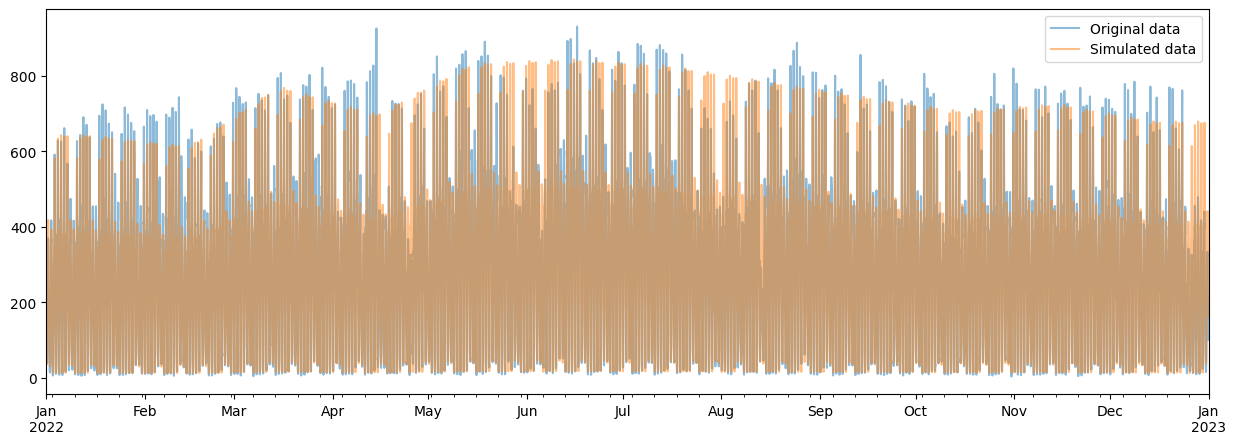

In [19]:
# Over lay the 2 
fig, ax = plt.subplots(figsize=(15, 5))
counts_clean.plot(ax=ax, label="Original data", alpha=0.5)
simulated_traffic.plot(ax=ax, label="Simulated data", alpha=0.5)
ax.legend()


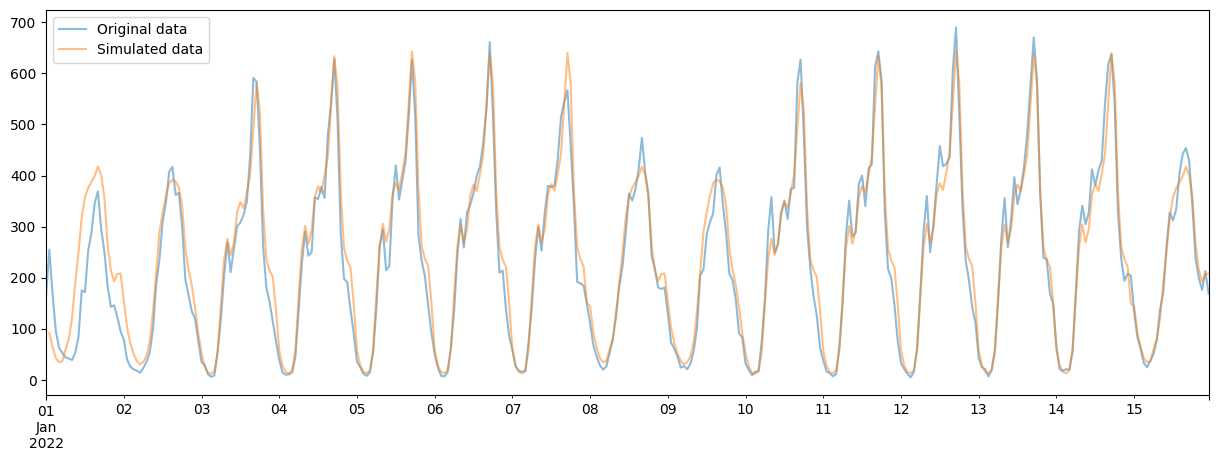

In [20]:
# Plot 1 week of data
fig, ax = plt.subplots(figsize=(15, 5))
time_range = slice("2022-01-01", "2022-01-15")
counts_clean.loc[time_range].plot(ax=ax, label="Original data", alpha=0.5)
simulated_traffic.loc[time_range].plot(ax=ax, label="Simulated data", alpha=0.5)
ax.legend()

Here we see one issue: On holidays (1rst of Januray), we don't simulate very well.
We should think about how to improve this.

## Exporting the data

If you want to use your profiles you might want to export them to a file.

In [21]:
from emiproc.profiles.temporal.io import to_yaml, from_yaml

# Save the profiles to a yaml file
save_path = local_dir / "traffic_profiles.yaml"
to_yaml(
    yaml_file=save_path,
    profiles=specific_day_profiles + [weekly_profile, mount_of_year_profile],
)


Then we can load them back and use them in emiproc.

In [22]:
profiles_loaded = from_yaml(save_path)
profiles_loaded

[SpecificDayProfile(ratios=array([[0.0276645 , 0.01768049, 0.01233449, 0.00821251, 0.00667069,
         0.00701996, 0.01142514, 0.0153898 , 0.02310829, 0.03638046,
         0.0478465 , 0.06085121, 0.0685225 , 0.07211272, 0.07429014,
         0.07650531, 0.08006721, 0.07691122, 0.06853824, 0.05057141,
         0.04116636, 0.03703494, 0.03974098, 0.03995494]]), size=24, specific_day=<SpecificDay.SATURDAY: 'saturday'>),
 SpecificDayProfile(ratios=array([[0.03282041, 0.02198224, 0.01528442, 0.01088085, 0.00787875,
         0.00647729, 0.00740923, 0.00985644, 0.01599582, 0.0283635 ,
         0.044964  , 0.06146847, 0.06969936, 0.07668531, 0.08186785,
         0.08336535, 0.08269663, 0.08008935, 0.07252718, 0.05493782,
         0.04579634, 0.03942576, 0.03014911, 0.01937852]]), size=24, specific_day=<SpecificDay.SUNDAY: 'sunday'>),
 SpecificDayProfile(ratios=array([[0.00902392, 0.00437855, 0.00242671, 0.00202702, 0.00293174,
         0.00915679, 0.02571388, 0.0404021 , 0.04721993, 0.041747  

## Data Analysis

Now that we have seen how to create and use profiles, we can perform 
a data analysis to see the profiles on each counter.

In [23]:
n_stations = len(gdf_stations)

# Create a list of profiles for each station
profiles_per_station = {}
valid_measurement = {}
series = {}
for station in gdf_stations["MSID"]:
    df_station = df.loc[df["MSID"] == station]
    serie_station = df_station.set_index("MessungDatZeit")['AnzFahrzeuge'].tz_localize("Europe/Zurich", ambiguous=True)
    # Count the valid measurements
    valid_measurement[station] = len(serie_station)
    serie_station = serie_station.reindex(axis)
    missing_ration = serie_station.isna().sum() / len(serie_station)
    if missing_ration > 0.1:
        print(f"To many missing values in {station}. Skipping this station.")
        continue
    serie_station = serie_station.interpolate(method='time')
    if pd.isna(serie_station).any():
        print(f"Missing values in {station}. Skipping this station.")
        continue
    # Save the serie for later use
    series[station] = serie_station


# Create the profiles 

df_cleaned = pd.DataFrame(series)
df_cleaned.head()

To many missing values in Z007M001. Skipping this station.
To many missing values in Z007M002. Skipping this station.
To many missing values in Z017M001. Skipping this station.
To many missing values in Z020M001. Skipping this station.
To many missing values in Z027M003. Skipping this station.
To many missing values in Z034M001. Skipping this station.
To many missing values in Z034M002. Skipping this station.
To many missing values in Z035M001. Skipping this station.
To many missing values in Z043M002. Skipping this station.
To many missing values in Z049M002. Skipping this station.
To many missing values in Z050M001. Skipping this station.
To many missing values in Z052M001. Skipping this station.
To many missing values in Z052M002. Skipping this station.
Missing values in Z055M002. Skipping this station.
To many missing values in Z056M004. Skipping this station.
To many missing values in Z060M005. Skipping this station.
To many missing values in Z060M006. Skipping this station.
To ma

,Z001M001,Z001M002,Z002M001,Z002M002,Z003M001,Z003M002,Z004M001,Z004M002,Z005M001,Z005M002,...,Z089M002,Z090M001,Z090M002,Z091M001,Z095M001,Z095M002,Z096M003,Z096M004,Z097M001,Z097M002
2022-01-01 00:00:00+01:00,166.0,182.0,130.0,64.0,65.0,140.0,70.0,83.0,46.0,54.0,...,55.0,120.0,96.0,191.0,72.0,80.0,26.0,43.0,229.0,285.0
2022-01-01 01:00:00+01:00,255.0,188.0,189.0,108.0,110.0,188.0,130.0,132.0,74.0,89.0,...,67.0,168.0,138.0,186.0,90.0,116.0,51.0,58.0,323.0,317.0
2022-01-01 02:00:00+01:00,168.0,140.0,122.0,82.0,83.0,131.0,105.0,92.0,52.0,53.0,...,62.0,120.0,109.0,149.0,83.0,100.0,35.0,41.0,227.0,248.0
2022-01-01 03:00:00+01:00,96.0,90.0,65.0,40.0,45.0,106.0,56.0,57.0,33.0,30.0,...,36.0,102.0,97.0,103.0,59.0,60.0,12.0,24.0,179.0,210.0
2022-01-01 04:00:00+01:00,63.0,80.0,26.0,33.0,30.0,68.0,51.0,60.0,21.0,13.0,...,45.0,76.0,71.0,101.0,50.0,55.0,9.0,14.0,149.0,204.0


Now we can create the profiles for each counter.

Note: the Profiles object support vectorization (i.e. one object can be used for multiple profiles).

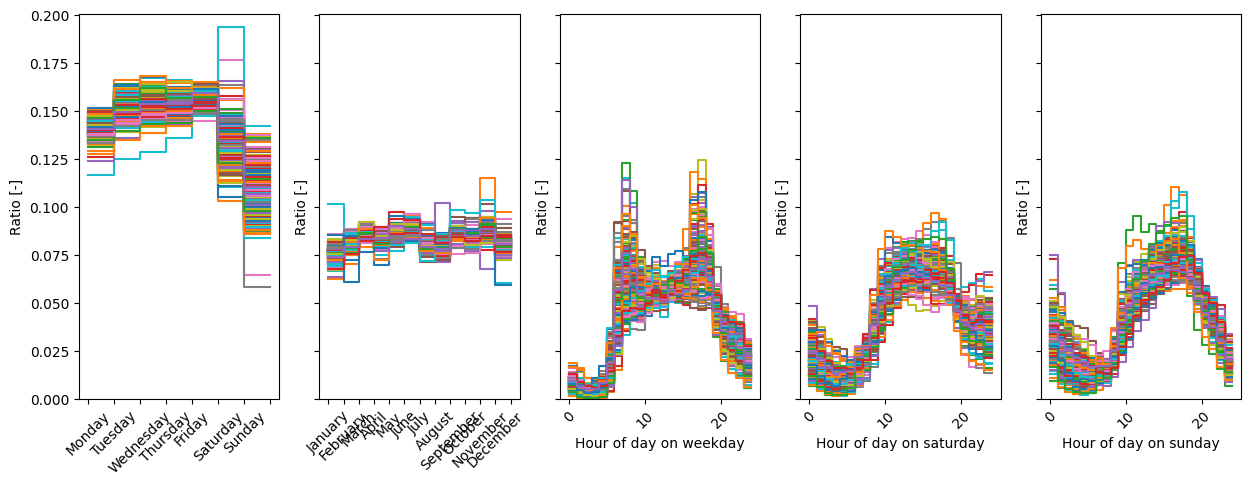

In [24]:
fig, ax = plt.subplots(ncols=2 + len(day_types), sharey=True, figsize=(15, 5))

df_to_ratios = lambda df: (df / df.sum(axis='index')).T.values


counts_per_weekday = df_cleaned.groupby(dt_index.dayofweek).mean()

profiles = {}

weekly_profile = WeeklyProfile(df_to_ratios(counts_per_weekday))
plot_profile(weekly_profile, ax=ax[0], ignore_limit=True)
profiles["weekly"] = weekly_profile

counts_mounthofyear = df_cleaned.groupby(dt_index.month).mean()
mount_of_year_profile = MounthsProfile(df_to_ratios(counts_mounthofyear))
plot_profile(mount_of_year_profile, ax=ax[1], ignore_limit=True)
profiles["mount_of_year"] = mount_of_year_profile



for col, day in enumerate(day_types):
    mask = dt_index.weekday.isin(get_days_as_ints(day))

    counts_this = df_cleaned.loc[mask].groupby(dt_index[mask].hour).sum()
    profile = SpecificDayProfile(df_to_ratios(counts_this), specific_day=day)

    plot_profile(profile, ax=ax[2 + col], ignore_limit=True)

    profiles[f"{day.name}"] = profile

Now that we have cleaned the data, we see that each station is having a quite homogeneous behaviour,
except for some slight differences.

* During the week some stations have morning peaks or evening peaks only.
This is because they measure only one way traffic, so the station measures people going to work or coming back home.
* Some stations have a higher traffic during the weekend especially satudray. They are very likely located near
areas where people go out (bars, restaurants, shops, etc.).

### Creating an average profile

With all these data. We can create an average profile for the city of Zurich.

We have to weight each counter with the total number of vehicles measured by the counter,
to ensure that stations with more traffic have a higher impact on the average profile.

When creating an average profile, we assume that traffic is sampled uniformly to the whole city.


In [25]:
serie = df_cleaned.sum(axis=1)
serie_to_ratios = lambda serie: (serie / serie.sum(axis='index')).values

profiles = []
counts_per_weekday = serie.groupby(dt_index.dayofweek).mean()
profiles.append(WeeklyProfile(serie_to_ratios(counts_per_weekday)))

counts_mounthofyear = serie.groupby(dt_index.month).mean()
profiles.append(MounthsProfile(serie_to_ratios(counts_mounthofyear)))



for col, day in enumerate(day_types):
    mask = dt_index.weekday.isin(get_days_as_ints(day))

    counts_this = serie.loc[mask].groupby(dt_index[mask].hour).sum()
    profiles.append(SpecificDayProfile(serie_to_ratios(counts_this), specific_day=day))
profiles

[WeeklyProfile(ratios=array([[0.14036589, 0.14952451, 0.15248972, 0.15279656, 0.15587846,
         0.13637535, 0.11256949]]), size=7),
 MounthsProfile(ratios=array([[0.07620255, 0.08186367, 0.08645871, 0.08231363, 0.08659582,
         0.08710387, 0.08016359, 0.07958428, 0.08665197, 0.08420896,
         0.08765587, 0.08119707]]), size=12),
 SpecificDayProfile(ratios=array([[0.00906564, 0.00569328, 0.00404374, 0.00418245, 0.00690026,
         0.01908826, 0.04984473, 0.06288486, 0.06048961, 0.05495954,
         0.0548376 , 0.0571124 , 0.05503949, 0.058058  , 0.05955774,
         0.06261542, 0.06984901, 0.07215781, 0.06479185, 0.04965276,
         0.03762368, 0.0321154 , 0.02919347, 0.020243  ]]), size=24, specific_day=<SpecificDay.WEEKDAY: 'weekday'>),
 SpecificDayProfile(ratios=array([[0.02409184, 0.01793791, 0.0131911 , 0.01083582, 0.01089714,
         0.01237153, 0.01786948, 0.02403787, 0.03669541, 0.0488225 ,
         0.05721198, 0.06242508, 0.06535358, 0.06578223, 0.06604232,
       

### Model quality analysis

We have shown above how to reconstruct the traffic from the profiles.
Here we would like to do the following:

* Assess the performance of the model for each site
* Make a global model by averaging the profiles of all sites and assessing the performance of the model

In [26]:
# TODO